In [1]:
import keras
from keras import backend as K
from keras.layers import GlobalAveragePooling2D,Conv2D,Multiply,BatchNormalization,AveragePooling2D,GlobalMaxPool2D
from keras.applications.mobilenet_v2 import MobileNetV2
from keras.applications.densenet import DenseNet121
from keras.applications.inception_v3 import InceptionV3 
from keras.applications.densenet import DenseNet121
from keras.applications.vgg16 import VGG16
from keras.applications import ResNet50
from keras.layers.core import Lambda
from keras.applications.xception import Xception
from keras.applications.mobilenet import MobileNet
from keras.layers import Dense,Reshape,Activation,Permute
from keras.models import Model
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import *
# from keras.utils import multi_gpu_model
from matplotlib import pyplot as plt
from keras.models import load_model
import os

In [2]:
def Global_Attention_Block(inputs):
        shape=K.int_shape(inputs)
#         avg_pool=GlobalAveragePooling2D()(inputs)
        avg_pool=AveragePooling2D(pool_size=(shape[1],shape[2])) (inputs)
        avg_pool=Conv2D(shape[3],1,padding='same')(avg_pool)
        avg_pool=Activation('sigmoid')(avg_pool)
        avg_pool=Conv2D(shape[3],1,padding='same')(avg_pool)
        avg_pool=Activation('sigmoid')(avg_pool)
        
        C_A= Multiply()([inputs,avg_pool])
        avg_pool=Lambda(lambda x: K.mean(x,axis=-1,keepdims=True))(C_A)
        avg_pool=Activation('sigmoid')(avg_pool)
        S_A= Multiply()([avg_pool,C_A])
        return S_A
        
        
    
    
        

In [3]:
def Category_Attention_Block(inputs,classes,k):
    shape=K.int_shape(inputs)
    F_1=Conv2D(k*classes,1,padding='same')(inputs)
    F_1=BatchNormalization()(F_1)
    F1=Activation('sigmoid')(F_1)
    
    F_2=F1
    x=GlobalMaxPool2D()(F_2)
    x=Reshape((classes,k)) (x)
    S=Lambda(lambda x: K.mean(x,axis=-1,keepdims=False))(x)
    
    x=Reshape((shape[1],shape[2],classes,k)) (F1)
    x=Lambda(lambda x: K.mean(x,axis=-1,keepdims=False))(x)
    x=Multiply()([S,x])
    M=Lambda(lambda x: K.mean(x,axis=-1,keepdims=True))(x)
    
    semantic=Multiply()([inputs,M])
    return semantic
        
    

In [4]:
def smooth_curve(points, factor=0.9):
    smoothed_points = []
    for point in points:
        if smoothed_points:
            previous = smoothed_points[-1]
            smoothed_points.append(previous * factor + point * (1 - factor))
        else:
            smoothed_points.append(point)
    return smoothed_points    

In [5]:
   
def plotmodel(history,name):
    
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(acc) + 1) 
    
    plt.figure(1)                  
    plt.plot(epochs,smooth_curve(acc))
    plt.plot(epochs,smooth_curve(val_acc))
    plt.ylabel('acc')
    plt.xlabel('epoch')
    plt.legend(['train_acc', 'val_acc'], loc='upper left')
    plt.savefig('acc_'+name+'.png')
    
    plt.figure(2)
    plt.plot(epochs,smooth_curve(loss))
    plt.plot(epochs,smooth_curve(val_loss))
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train_loss', 'val_loss'], loc='upper right')
    plt.savefig('loss_'+name+'.png')

In [6]:
def get_base_model(model_name,img_size):
    if(model_name=='vgg16'):
        base_model=VGG16(include_top=False,weights='imagenet',input_shape=(img_size,img_size,3))
    if model_name =='densenet121':
        base_model=DenseNet121       (include_top=False, weights='imagenet',input_shape=(image_size,image_size,3))
    if(model_name=='inceptionv3'):
        base_model=InceptionV3(include_top=False,weights='imagenet',input_shape=(img_size,img_size,3))
    if(model_name=='resnet50'):
        base_model=ResNet50(include_top=False,weights='imagenet',input_shape=(img_size,img_size,3))
    if(model_name=='mobilenet'):
        base_model=MobileNet(include_top=False,weights='imagenet',input_shape=(img_size,img_size,3))
    if(model_name=='xception'):
        base_model=Xception(include_top=False,weights='imagenet',input_shape=(img_size,img_size,3))
    return base_model

In [14]:
def train_model(model,image_size,batch_size,save_name,lr1,lr2,Epochs1,Epochs2):
#     dataParam={'messidor': [667,242,2,'./dataset/train','./dataset/test']}
    
#     train_num,valid_num,classes,train_dir,test_dir = dataParam[dataset]
    train_num=957
    #957,243
    valid_num=243
    train_dir='./new_data/final/train'
    test_dir='./new_data/final/valid'
    train=ImageDataGenerator(horizontal_flip=True,vertical_flip=True,rotation_range=90)
    
    valid=ImageDataGenerator()
    
    train_data=train.flow_from_directory(train_dir,target_size=(image_size,image_size),
                                         shuffle=True,batch_size=batch_size)
    test=valid.flow_from_directory(test_dir,target_size=(image_size,image_size),shuffle=True
                                   ,batch_size=batch_size)
    
    
    lr_decay=ReduceLROnPlateau(monitor='val_loss', factor=0.8, patience=3, verbose=1)
    save_model=ModelCheckpoint('new/'+save_name+'{epoch:02d}.h5', monitor='val_loss',period=20)
    
    for layer in base_model.layers:
        layer.trainable=False
    model.compile(optimizer=Adam(learning_rate=lr1,decay=0.00001),loss='categorical_crossentropy',metrics=['acc'])
    model.fit(train_data,steps_per_epoch=train_num/batch_size
                        ,validation_data=test,validation_steps=valid_num/batch_size,epochs=Epochs1,workers=1,
                       callbacks=[lr_decay,save_model])
    for layer in base_model.layers:
        layer.trainable = True
        
    model.compile(optimizer=Adam(learning_rate=lr2,decay=0.00001),loss='categorical_crossentropy',metrics=['acc'])
    history=model.fit(train_data,steps_per_epoch=train_num/batch_size
                        ,validation_data=test,validation_steps=valid_num/batch_size,epochs=Epochs2,workers=2,
                       callbacks=[lr_decay,save_model])
    
    return history
        
        
    

In [15]:
loss_fun= 'categorical_crossentropy'  
k=5
lr1=0.005
lr2=0.0001
batch_size= 16
image_size=512
classes=5

base_model=get_base_model('densenet121',image_size)
base_in=base_model.input
base_out=base_model.output

x=Global_Attention_Block(base_out)
base_out=Category_Attention_Block(x,classes,k)

x=GlobalAveragePooling2D()(base_out)
out=Dense(classes,activation='softmax')(x)

parallel_model=Model(base_model.input,out)
parallel_model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 512, 512, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d_6 (ZeroPadding2  (None, 518, 518, 3)  0          ['input_4[0][0]']                
 D)                                                                                               
                                                                                                  
 conv1/conv (Conv2D)            (None, 256, 256, 64  9408        ['zero_padding2d_6[0][0]']       
                                )                                                           

Found 957 images belonging to 5 classes.
Found 243 images belonging to 5 classes.
59/59 [==============================] - 256s 4s/step - loss: 1.6255 - acc: 0.3187 - val_loss: 1.3424 - val_acc: 0.4239 - lr: 0.0050
Epoch 1/20
59/59 [==============================] - 1296s 21s/step - loss: 1.3847 - acc: 0.3323 - val_loss: 1.5581 - val_acc: 0.2099 - lr: 1.0000e-04
Epoch 2/20
59/59 [==============================] - 1264s 21s/step - loss: 1.1303 - acc: 0.4838 - val_loss: 1.0699 - val_acc: 0.5021 - lr: 1.0000e-04
Epoch 3/20
59/59 [==============================] - 1261s 21s/step - loss: 1.0113 - acc: 0.5737 - val_loss: 1.1657 - val_acc: 0.4774 - lr: 1.0000e-04
Epoch 4/20
59/59 [==============================] - 1269s 21s/step - loss: 0.9357 - acc: 0.6113 - val_loss: 0.9353 - val_acc: 0.5761 - lr: 1.0000e-04
Epoch 5/20
59/59 [==============================] - 1268s 21s/step - loss: 0.8670 - acc: 0.6635 - val_loss: 0.9307 - val_acc: 0.5473 - lr: 1.0000e-04
Epoch 6/20
59/59 [=================

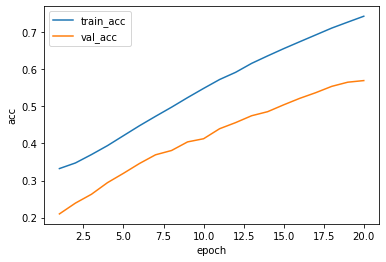

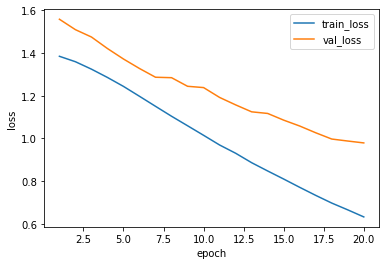

In [16]:
history=train_model(parallel_model,image_size,batch_size,'densenet121',lr1,lr2,1,20)
plotmodel(history,'densenet121')